# Fun with Gamma Ray Bursts (GRBs)

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import requests
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from scipy.stats import norm

We look at the latest database of GRBs, downloadable at https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt, while its information can be found at https://user-web.icecube.wisc.edu/~grbweb_public/Variables.html.

In [3]:
r = requests.get('https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt')
with open("Summary_table.txt", 'wb') as f:
    f.write(r.content)

data = np.loadtxt("Summary_table.txt", dtype='str',unpack='True')

with open("Summary_table.txt",'r') as f:
    names= np.array([n.strip().replace(" ","_") for n in f.readlines()[1].replace("#","").replace("\n","").lstrip().split('    ') if n.strip()!=''])

In [4]:
names

array(['GRB_name', 'GRB_name_Fermi', 'T0', 'ra', 'decl', 'pos_error',
       'T90', 'T90_error', 'T90_start', 'fluence', 'fluence_error',
       'redshift', "'T100'", 'GBM_located', 'mjd_(T0)'], dtype='<U14')

In [5]:
GRB_name=np.array(data[0], dtype=str)
GRB_name_Fermi=np.array(data[1], dtype=str)
T0=np.array(data[2], dtype=str)
ra=np.array(data[3], dtype=float)
decl=np.array(data[4], dtype=float)
pos_error=np.array(data[5], dtype=float)
T90=np.array(data[6],dtype=float)
T90_error=np.array(data[7],dtype=float)
T90_start=np.array(data[8], dtype=str)
fluence=np.array(data[9], dtype=float)
fluence_error=np.array(data[10], dtype=float)
redshift=np.array(data[11], dtype=float)
T100=np.array(data[12],dtype=float)
mjd_T0=np.array(data[14], dtype=float)

# 1D analysis - T90 parameter

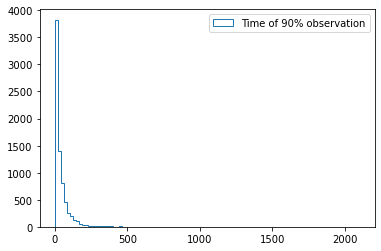

In [6]:
plt.hist(T90[T90!=-999], bins=100, histtype='step', label='Time of 90% observation')
plt.legend();

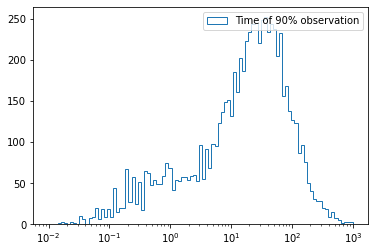

In [7]:
plt.hist(T90, bins=np.logspace(-2,3,100), histtype='step', label='Time of 90% observation')
plt.semilogx()
plt.legend();

In [8]:
logT90 = np.log10(T90)
logT90=logT90[~np.isnan(logT90)] 
skT90 = logT90[:,np.newaxis]

C:\Users\loren\AppData\Local\Temp\ipykernel_2560\3803698171.py:1: RuntimeWarning: invalid value encountered in log10
  logT90 = np.log10(T90)


In [19]:
bwrange = np.linspace(0.01,1.0, 10)
print(bwrange)
K = 5 # 5-fold cross validation
grid = GridSearchCV(KernelDensity(), {'bandwidth': bwrange}, cv= K)
grid.fit(skT90)
h_opt = grid.best_params_['bandwidth']
print(h_opt)

[0.01 0.12 0.23 0.34 0.45 0.56 0.67 0.78 0.89 1.  ]
0.12


In [20]:
#kde = KernelDensity(kernel='gaussian', bandwidth=0.08).fit(skT90) 
kde = KernelDensity(kernel='gaussian', bandwidth=h_opt).fit(skT90) 
xgrid=np.logspace(-3,3,100)
ygrid = np.exp(kde.score_samples(np.log10(xgrid)[:,np.newaxis]))

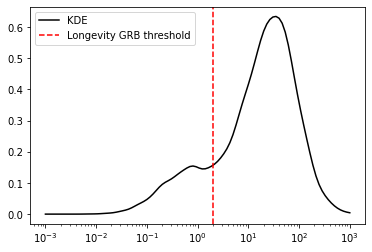

In [21]:
plt.plot(xgrid, ygrid, 'k', label='KDE')
plt.axvline(2, linestyle='dashed', color='red', label='Longevity GRB threshold')
plt.semilogx()
plt.legend();

I can ask myself if this distribution could be a result of multiple gaussians.

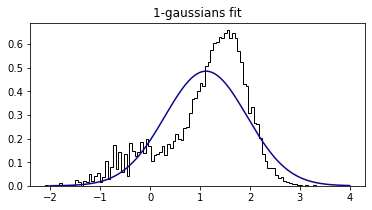

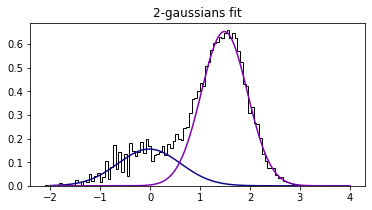

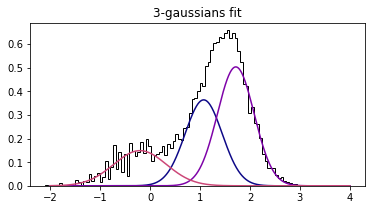

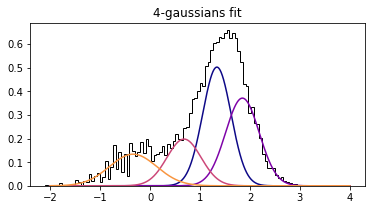

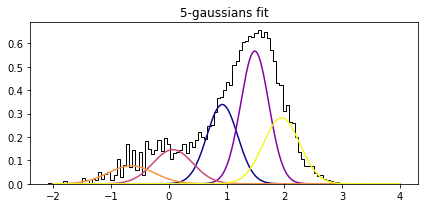

In [36]:
num_gauss = [1, 2, 3, 4, 5]
x = np.linspace(-2, 4, 1000)
colors = plt.cm.plasma(np.linspace(0, 1, 5))
aic_values = []

for n in num_gauss:
        
    gm = GaussianMixture(n_components=n, covariance_type='diag', random_state=42)
    f = gm.fit(skT90)
    
    aic = gm.aic(skT90)
    aic_values.append(aic)

    means = f.means_
    covariances = f.covariances_
    variances = np.sqrt(covariances)
    weights = f.weights_
    
    plt.figure(figsize=(6, 3))
    plt.hist(skT90, bins=100, histtype='step', color='black', density=True)
    
    for i in range(n):
        gi = norm(loc=means[i], scale=variances[i]).pdf(x)
        plt.plot(x, gi*weights[i], color=colors[i])
        plt.title(str(i+1) + '-gaussians fit')
        
plt.tight_layout() 
plt.show()    

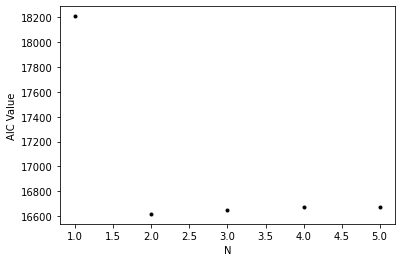

The lower AIC value corresponds to the best fitting model, therefore the 2-gaussian model is the one that fits better the data.


In [23]:
plt.scatter(num_gauss, aic_values, marker='.', color='black')
plt.xlabel('N')
plt.ylabel('AIC Value')
plt.show()
print('The lower AIC value corresponds to the best fitting model, therefore the 2-gaussian model is the one that fits better the data.')

In [33]:
n_gauss = 2
gm = GaussianMixture(n_components=n_gauss, covariance_type='diag', max_iter=100, random_state=42)
fit = gm.fit(skT90)

means = fit.means_
covariances = fit.covariances_
variances = np.sqrt(covariances)
weights = fit.weights_

Text(0.5, 1.0, 'Gaussian Mixture with 2 gaussians')

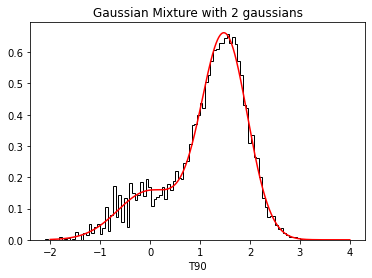

In [34]:
logprob = gm.score_samples(x.reshape(-1, 1))
pdf = np.exp(logprob)

plt.hist(skT90, 100, density=True, histtype='step', color='black')

plt.plot(x, pdf, '-r')

plt.xlabel('T90')
plt.title('Gaussian Mixture with 2 gaussians')

I could now try to find a more visualizable differentiation between short and long GRB, through a clustering using the flux and the duration of the events.

I prepare the data for this purpose

In [37]:
T90_reduced = T90[np.logical_and(T90>0, fluence>0)]
fluence_reduced = fluence[np.logical_and(T90>0, fluence>0)]

In [38]:
X = []
for i in range(len(T90_reduced)):
    entrata_T90 = np.log10(T90_reduced[i])
    entrata_fluence_1 = np.log10(fluence_reduced[i])
    X.append([entrata_T90, entrata_fluence_1])
    
X = np.array(X)

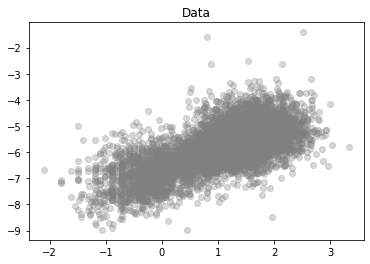

In [39]:
plt.title('Data')
plt.scatter(X[:,0],X[:,1],color='gray',alpha=0.3);

# KMeans clustering

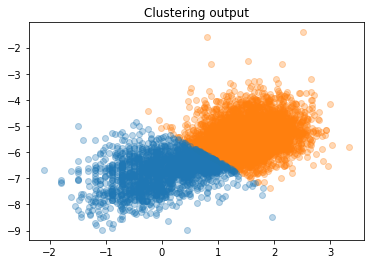

In [42]:
from sklearn.cluster import KMeans
from sklearn import preprocessing

clf = KMeans(n_clusters=2,n_init='auto') 
clf.fit(X)
centers = clf.cluster_centers_ 
labels = clf.predict(X) 

colors = ['C1', 'C0', 'C2']
for ii in range(3):
    plt.scatter(X[labels==ii,0], X[labels==ii,1], 
                color=colors[ii],alpha=0.3)

plt.title('Clustering output');

Here i can see the distinction between short and long GRBs as two clusters. But actually there would be a third group, called the **Intermediate GRBs**, which is, as the name says, a GRB which duration is between a short and a long GRB.

In order to visualize this, i could try to put a third cluster in the Kmeans clustering: 

In [45]:
n_clusters = 3
scaler = preprocessing.StandardScaler()
clf = KMeans(n_clusters, n_init='auto')
clf.fit(scaler.fit_transform(X))

KMeans(n_clusters=3)

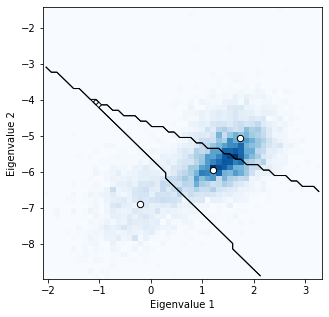

In [46]:
# Make some plots
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()

# Compute a 2D histogram  of the input
H, xedges, yedges = np.histogram2d(X[:,0], X[:,1], 50)

# plot density
ax.imshow(H.T, origin='lower', interpolation='nearest', aspect='auto',
          extent=[xedges[0], xedges[-1],
                  yedges[0], yedges[-1]],
          cmap='Blues')

# plot cluster centers
cluster_centers = scaler.inverse_transform(clf.cluster_centers_)
ax.scatter(cluster_centers[:, 0], cluster_centers[:, 1],
           s=40, c='w', edgecolors='k')

# plot cluster boundaries
x_centers = 0.5 * (xedges[1:] + xedges[:-1])
y_centers = 0.5 * (yedges[1:] + yedges[:-1])

Xgrid = np.meshgrid(x_centers, y_centers)
Xgrid = np.array(Xgrid).reshape((2, 50 * 50)).T

H = clf.predict(scaler.transform(Xgrid)).reshape((50, 50))

for i in range(n_clusters):
    Hcp = H.copy()
    flag = (Hcp == i)
    Hcp[flag] = 1
    Hcp[~flag] = 0

    ax.contour(x_centers, y_centers, Hcp, [-0.5, 0.5],
               linewidths=1, colors='k')

    H = clf.predict(scaler.transform(Xgrid)).reshape((50, 50))
    
ax.set_xlim(xedges[0], xedges[-1])
ax.set_ylim(yedges[0], yedges[-1])

ax.set_xlabel('Eigenvalue 1')
ax.set_ylabel('Eigenvalue 2')

plt.show()

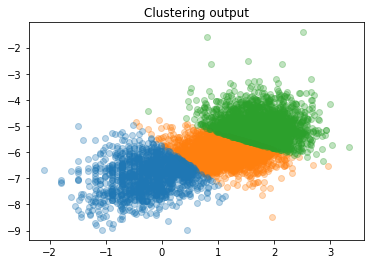

In [43]:
from sklearn.cluster import KMeans
from sklearn import preprocessing

clf = KMeans(n_clusters=3,n_init='auto') 
clf.fit(X)
centers = clf.cluster_centers_ 
labels = clf.predict(X) 

colors = ['C1', 'C0', 'C2']
for ii in range(3):
    plt.scatter(X[labels==ii,0], X[labels==ii,1], 
                color=colors[ii],alpha=0.3)

plt.title('Clustering output');

# Mean-shift clustering

In [47]:
n_clusters = 3
scaler = preprocessing.StandardScaler()
Y = scaler.fit_transform(X)
clf = KMeans(n_clusters, n_init='auto')
clf.fit(Y)
centers = clf.cluster_centers_

In [48]:
# Compute the Mean-shift clustering
from sklearn.cluster import MeanShift, estimate_bandwidth

#scaler = preprocessing.StandardScaler()
bandwidth = 0.4
#bandwidth = estimate_bandwidth(X, quantile=0.6) # this takes a long time...beware
ms = MeanShift(bandwidth=bandwidth, 
               bin_seeding=True, 
               cluster_all=False,
               seeds = centers)
ms.fit(Y)

MeanShift(bandwidth=0.4, bin_seeding=True, cluster_all=False,
          seeds=array([[-1.61748905, -1.32060066],
       [ 0.74874374,  0.94992866],
       [ 0.11661304, -0.17891884]]))

[-1  0  1]
0.4
number of estimated clusters : 2


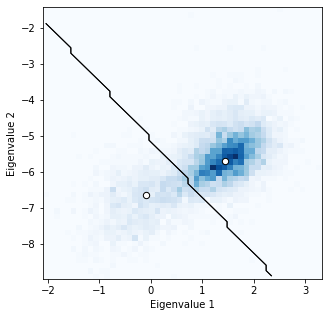

In [50]:
labels_unique = np.unique(ms.labels_)
n_clusters = len(labels_unique[labels_unique >= 0])
print(labels_unique)
print(bandwidth)
print("number of estimated clusters :", n_clusters)

# Make some plots
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()

# Compute a 2D histogram  of the input
H, xedges, yedges = np.histogram2d(X[:,0], X[:,1], 50)

# plot density
ax.imshow(H.T, origin='lower', interpolation='nearest', aspect='auto',
          extent=[xedges[0], xedges[-1],
                  yedges[0], yedges[-1]],
          cmap='Blues')

# plot cluster centers
cluster_centers = scaler.inverse_transform(ms.cluster_centers_)
ax.scatter(cluster_centers[:, 0], cluster_centers[:, 1],
           s=40, c='w', edgecolors='k')

# plot cluster boundaries
x_centers = 0.5 * (xedges[1:] + xedges[:-1])
y_centers = 0.5 * (yedges[1:] + yedges[:-1])

Xgrid = np.meshgrid(x_centers, y_centers)
Xgrid = np.array(Xgrid).reshape((2, 50 * 50)).T

H = ms.predict(scaler.transform(Xgrid)).reshape((50, 50))

for i in range(n_clusters):
    Hcp = H.copy()
    flag = (Hcp == i)
    Hcp[flag] = 1
    Hcp[~flag] = 0

    ax.contour(x_centers, y_centers, Hcp, [-0.5, 0.5],
               linewidths=1, colors='k')
 
    H = ms.predict(scaler.transform(Xgrid)).reshape((50, 50))
    
ax.set_xlim(xedges[0], xedges[-1])
ax.set_ylim(yedges[0], yedges[-1])

ax.set_xlabel('Eigenvalue 1')
ax.set_ylabel('Eigenvalue 2')

plt.show()

However, from a MeanShift clustering, it ends up that the number of cluster is 2. So, maybe, the intermediate GRBs do not put a so important division as it is for short-long GRBs.